BraTS Challenge Demo-Notebook

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from dataset_utils import slice_cube, split_cube
from visualization_utils import plot_confusion_matrix, plot_loss, animate_cube, get_positives_negatives_from_cm
from data_loading import get_train_test_iters
torch.manual_seed(42)
from Architectures.unet_3d import UNet3D
from Architectures.unet_3d_context import UNet3D_Mini
from Architectures.unet_2d import UNet2D
from train import train_model
from custom_losses import DiceLoss, FocalTverskyLoss

Data Loading

Create the model

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 3060 Laptop GPU


Training Loop

In [4]:
# hyperparameters
train_3d = True
add_context = False
compute_test_loss = True
epochs = 20
learning_rate = 0.001

# init model
if train_3d:
    if add_context:
        model = UNet3D_Mini(num_modalities=4, num_classes=4).to(device)
    else:
        #model = SmallSegNet(in_channels=4, num_classes=4, img_height=96, img_width=96).to('cuda:0')
        model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    model = UNet2D().to(device)
weights_path = os.path.join('..','Weights')
weights_filename = 'SmallSegNet_epoch14_loss111.582.h5'
#model.load_state_dict(torch.load(os.path.join(weights_path, weights_filename)))
# init optimizer and loss_fn
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = DiceLoss()

In [5]:
batch_size = 3
dataset_path = os.path.join('..', 'Task01_BrainTumour', 'cropped')

In [6]:
# Training
print(f'training {model.__class__.__name__}:')
train_losses, test_losses = train_model(model, optim, loss_fn, epochs, device, dataset_path, batch_size, train_3d, add_context, compute_test_loss)

training SmallSegNet:
epoch 0: epoch_train_loss=108.770, epoch_test_loss=105.609
epoch 1: epoch_train_loss=108.448, epoch_test_loss=105.542
epoch 2: epoch_train_loss=108.340, epoch_test_loss=105.401
epoch 3: epoch_train_loss=108.232, epoch_test_loss=105.302
epoch 4: epoch_train_loss=108.171, epoch_test_loss=105.314


Plot losses

Loss curve using DiceLoss():


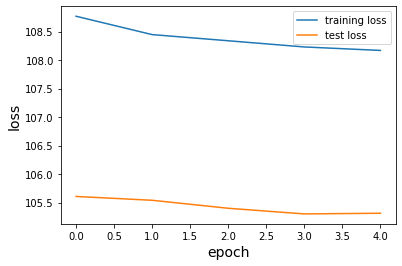

In [7]:
print(f'Loss curve using {loss_fn}:')
plot_loss(train_losses, test_losses)

Load inference model

In [8]:
weights_path = os.path.join('..','Weights')
weights_filename = 'SmallSegNet_epoch14_loss111.582.h5'
if train_3d:
    if add_context:
        inference_model = UNet3D_Mini(num_modalities=4, num_classes=4).to(device)
    else:
        inference_model = UNet3D(num_modalities=4, num_classes=4).to(device)
else:
    inference_model = UNet2D().to(device)
inference_model = SmallSegNet(in_channels=4, num_classes=4, img_height=96, img_width=96).to(device)
inference_model.load_state_dict(torch.load(os.path.join(weights_path, weights_filename)))
inference_model.eval();

Predict

In [9]:
train_iter, test_iter = get_train_test_iters(dataset_path, batch_size=batch_size, shuffle=True, num_workers=0)
batch = train_iter.next()

torch.Size([160, 192, 192])


<IPython.core.display.Javascript object>


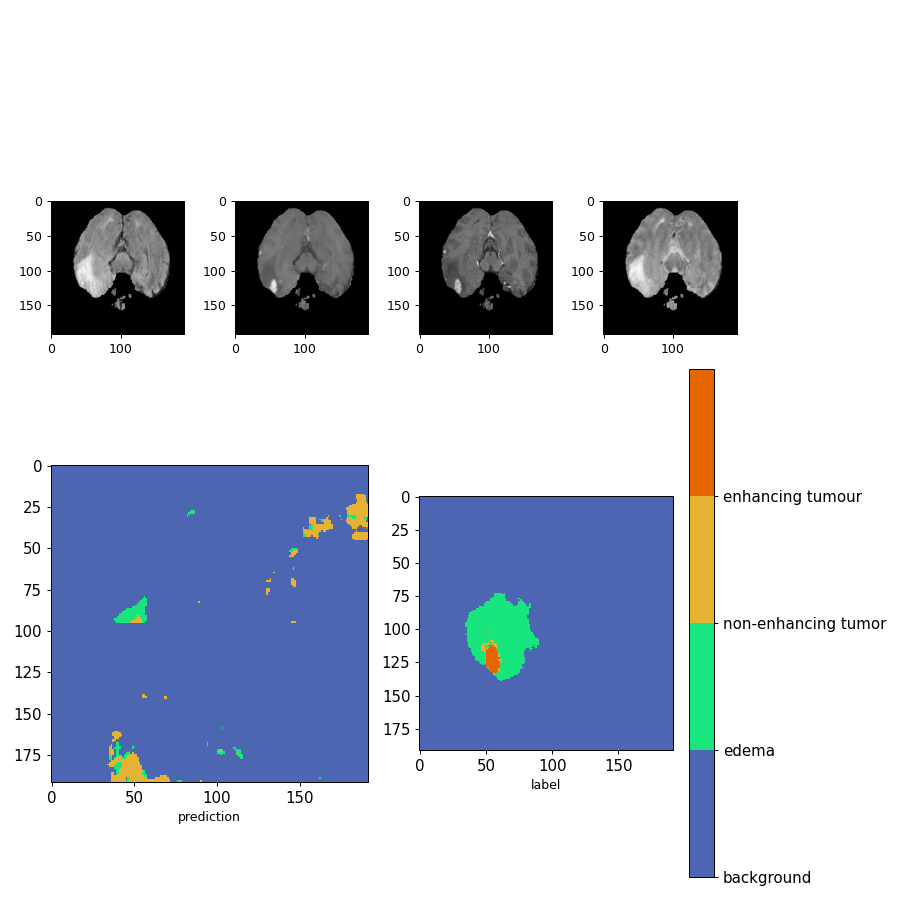

In [11]:
%matplotlib notebook
ani = animate_cube(inference_model, batch, add_context, device, train_3d)
plt.show()
#del batch

# Confusion Matrix

In [13]:
#train_iter, test_iter = get_train_test_iters(os.path.join('..', 'Task01_BrainTumour', 'cropped'), batch_size=batch_size, shuffle=False, num_workers=0)

#cf_matrix_visu, cf_matrix = plot_confusion_matrix(test_iter, model, train_3d, add_context, device=device)
#cf_matrix_visu.show()

In [14]:
#get_positives_negatives_from_cm(cf_matrix.to_numpy())